#  Sélection de variables : une introduction




<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmodelisation%204_featureselection%C2%BB&security.allowlist.enabled=false)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=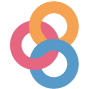)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)

Pour illustrer le travail de données nécessaire pour faire de la sélection de variables,
nous allons partir du même jeu de données que précédemment,
c'est-à-dire les résultats des élections US 2020 présentés dans l'[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles US
croisées à des variables socio-démographiques.
Le code 
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).

Le code 
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).


In [ ]:
#!pip install geopandas

import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

```
## 3585
```

In [ ]:
import getdata
votes = getdata.create_votes_dataframes()

Jusqu'à présent, nous avons supposé que les variables utiles à la prévision du
vote Républicain étaient connues du modélisateur. Nous n'avons ainsi exploité qu'une partie
limitée des variables disponibles dans nos données. Néanmoins, outre le fléau
computationnel que représenterait la construction d'un modèle avec un grand
nombre de variables, le choix d'un nombre restreint de variables
(modèle parcimonieux) limite le risque de sur-apprentissage.

Comment, dès-lors, choisir le bon nombre de variables et la meilleure
combinaison de ces variables ? Il existe de multiples méthodes, parmi lesquelles :

* se fonder sur des critères statistiques de performance qui pénalisent les
modèles non parcimonieux. Par exemple, le BIC.
* techniques de *backward elimination*.
* construire des modèles pour lesquels la statistique d'intérêt pénalise l'absence
de parcimonie (ce que l'on va souhaiter faire ici). 

# Principe du LASSO

## Principe général

La classe des modèles de *feature selection* est ainsi très vaste et regroupe
un ensemble très diverse de modèles. Nous allons nous focaliser sur le LASSO
(*Least Absolute Shrinkage and Selection Operator*)
qui est une extension de la régression linéaire qui vise à sélectionner des
modèles *sparses*. Ce type de modèle est central dans le champ du 
*Compressed sensing* (où on emploie plutôt le terme 
de *L1-regularization* que de LASSO). Le LASSO est un cas particulier des
régressions elastic-net dont un autre cas fameux est la régression *ridge*.
Contrairement à la régression linéaire classique, elles fonctionnent également
dans un cadre où $p>N$, c'est à dire où le nombre de régresseurs est très grand puisque supérieur
au nombre d'observations.

## Pénalisation

En adoptant le principe d'une fonction objectif pénalisée,
le LASSO permet de fixer un certain nombre de coefficients à 0.
Les variables dont la norme est non nulle passent ainsi le test de sélection. 

Le LASSO est un programme d'optimisation sous contrainte. On cherche à trouver l'estimateur $\beta$ qui minimise l'erreur quadratique (régression linéaire) sous une contrainte additionnelle régularisant les paramètres:
$$
\min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) \\
\text{s.t. } \sum_{j=1}^p |\beta_j| \leq t
$$
Ce programme se reformule grâce au Lagrangien est permet ainsi d'obtenir un programme de minimisation plus maniable : 
$$
\beta^{\text{LASSO}} = \arg \min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) + \alpha \sum_{j=1}^p |\beta_j| = \arg \min_{\beta} ||y-X\beta||_{2}^{2} + \alpha ||\beta||_1
$$
où $\lambda$ est une réécriture de la régularisation précédente. 

<!-- warning: sélection de variables corrélées -->

## Première régression LASSO

Avant de se lancer dans les exercices, on va éliminer quelques colonnes redondantes, 
celles qui concernent les votes des partis concurrents (forcément très
corrélés au vote Républicain...)  :


In [ ]:
df2 = votes.loc[:,~votes.columns.str.endswith(
  ('_democrat','_green','_other', 'per_point_diff', 'per_dem')
  )]

**Exercice 1 : Premier LASSO**


In [ ]:
# packages utiles
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns

1. Préparez les variables à utiliser.
* Ne garder que les colonnes numériques (idéalement on transformerait
les variables non numériques en numériques)
* Remplacer les valeurs infinies par des NaN
* Standardiser les variables avec `StandardScaler`


2. On cherche toujours à prédire la variable `per_gop`. Créez un échantillon d'entraînement et un échantillon test. 



3. Estimer un modèle LASSO pénalisé avec $alpha = 0.1$. Afficher les valeurs des coefficients. Quelles variables ont une valeur non nulle ?

Les variables sélectionnées sont :

```
## /opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
##   warnings.warn(
```

```
## ['ALAND', 'FIPS_y', 'INTERNATIONAL_MIG_2017', 'DOMESTIC_MIG_2014', 'DOMESTIC_MIG_2017', 'RESIDUAL_2010', 'RESIDUAL_2019', 'R_death_2012', 'R_death_2019', 'R_NATURAL_INC_2019', 'R_INTERNATIONAL_MIG_2011', 'R_DOMESTIC_MIG_2012', "Percent of adults with a bachelor's degree or higher, 1990", 'Percent of adults with a high school diploma only, 2000', "Percent of adults with a bachelor's degree or higher, 2000", "Percent of adults with a bachelor's degree or higher, 2015-19", 'Rural_urban_continuum_code_2013', 'Metro_2013', 'Unemployment_rate_2002', 'Unemployment_rate_2003', 'Unemployment_rate_2012', 'Rural-urban_Continuum_Code_2003', 'Rural-urban_Continuum_Code_2013', 'CI90LB517P_2019', 'candidatevotes_2016_republican', 'share_2012_republican', 'share_2016_republican']
```

Certaines variables font sens, comme les variables d'éducation par exemple. Notamment, un des meilleurs prédicteurs pour le score des Républicains en 2020 est... le score des Républicains (et mécaniquement des démocrates) en 2016.

Par ailleurs, on sélectionne des variables redondantes. Une phase plus approfondie de nettoyage des données serait nécessaire ;

4. Montrer que les variables sélectionnées sont parfois très corrélées. 




5. Comparer la performance de ce modèle parcimonieux avec celle d'un modèle avec plus de variables 




6. Utiliser la fonction `lasso_path` pour évaluer le nombre de paramètres sélectionnés par LASSO lorsque $\alpha$
varie (parcourir $\alpha \in [0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0]$ ). 



On voit que plus alpha est élevé, moins le modèle sélectionne de variables.



## Validation croisée pour sélectionner le modèle

Quel $\alpha$ faut-il privilégier ? Pour cela, 
il convient d'effectuer une validation croisée afin de choisir le modèle pour
lequel les variables qui passent la phase de sélection permettent de mieux
prédire le résultat Républicain.



```
## alpha optimal : 0.001
```



Les variables sélectionnées sont : 

```
## ['ALAND', 'AWATER', 'votes_gop', 'diff', 'Rural-urban_Continuum Code_2003', 'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2013', 'Economic_typology_2015', 'CENSUS_2010_POP', 'N_POP_CHG_2013', 'N_POP_CHG_2016', 'N_POP_CHG_2017', 'N_POP_CHG_2018', 'N_POP_CHG_2019', 'Births_2011', 'Births_2015', 'Deaths_2015', 'Deaths_2017', 'Deaths_2018', 'NATURAL_INC_2012', 'NATURAL_INC_2013', 'NATURAL_INC_2014', 'NATURAL_INC_2016', 'NATURAL_INC_2018', 'INTERNATIONAL_MIG_2010', 'INTERNATIONAL_MIG_2011', 'INTERNATIONAL_MIG_2012', 'INTERNATIONAL_MIG_2013', 'INTERNATIONAL_MIG_2014', 'INTERNATIONAL_MIG_2015', 'INTERNATIONAL_MIG_2016', 'INTERNATIONAL_MIG_2017', 'INTERNATIONAL_MIG_2018', 'INTERNATIONAL_MIG_2019', 'DOMESTIC_MIG_2010', 'DOMESTIC_MIG_2012', 'DOMESTIC_MIG_2013', 'DOMESTIC_MIG_2015', 'DOMESTIC_MIG_2016', 'DOMESTIC_MIG_2018', 'NET_MIG_2011', 'NET_MIG_2014', 'NET_MIG_2018', 'NET_MIG_2019', 'RESIDUAL_2010', 'RESIDUAL_2011', 'RESIDUAL_2012', 'RESIDUAL_2013', 'RESIDUAL_2014', 'RESIDUAL_2015', 'RESIDUAL_2016', 'RESIDUAL_2017', 'RESIDUAL_2018', 'RESIDUAL_2019', 'GQ_ESTIMATES_BASE_2010', 'GQ_ESTIMATES_2013', 'GQ_ESTIMATES_2015', 'GQ_ESTIMATES_2017', 'R_birth_2011', 'R_birth_2013', 'R_birth_2014', 'R_birth_2016', 'R_birth_2017', 'R_birth_2019', 'R_death_2011', 'R_death_2012', 'R_death_2013', 'R_death_2014', 'R_death_2015', 'R_death_2016', 'R_death_2017', 'R_death_2018', 'R_death_2019', 'R_NATURAL_INC_2012', 'R_NATURAL_INC_2015', 'R_NATURAL_INC_2017', 'R_NATURAL_INC_2018', 'R_NATURAL_INC_2019', 'R_INTERNATIONAL_MIG_2011', 'R_INTERNATIONAL_MIG_2012', 'R_INTERNATIONAL_MIG_2013', 'R_INTERNATIONAL_MIG_2014', 'R_INTERNATIONAL_MIG_2015', 'R_INTERNATIONAL_MIG_2016', 'R_INTERNATIONAL_MIG_2017', 'R_INTERNATIONAL_MIG_2018', 'R_INTERNATIONAL_MIG_2019', 'R_DOMESTIC_MIG_2011', 'R_DOMESTIC_MIG_2012', 'R_DOMESTIC_MIG_2013', 'R_DOMESTIC_MIG_2015', 'R_DOMESTIC_MIG_2016', 'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2014', 'R_NET_MIG_2017', 'R_NET_MIG_2019', '2003 Rural-urban Continuum Code', 'Less than a high school diploma, 1970', 'High school diploma only, 1970', 'Some college (1-3 years), 1970', 'Four years of college or higher, 1970', 'Percent of adults with less than a high school diploma, 1970', 'Percent of adults with a high school diploma only, 1970', 'Percent of adults completing some college (1-3 years), 1970', 'Percent of adults completing four years of college or higher, 1970', 'Less than a high school diploma, 1980', 'High school diploma only, 1980', 'Some college (1-3 years), 1980', 'Four years of college or higher, 1980', 'Percent of adults with less than a high school diploma, 1980', 'Percent of adults with a high school diploma only, 1980', 'Percent of adults completing some college (1-3 years), 1980', 'Percent of adults completing four years of college or higher, 1980', 'Less than a high school diploma, 1990', 'Percent of adults with less than a high school diploma, 1990', 'Percent of adults with a high school diploma only, 1990', 'Less than a high school diploma, 2000', 'High school diploma only, 2000', "Some college or associate's degree, 2000", "Bachelor's degree or higher, 2000", 'Percent of adults with less than a high school diploma, 2000', 'Percent of adults with a high school diploma only, 2000', "Percent of adults completing some college or associate's degree, 2000", "Percent of adults with a bachelor's degree or higher, 2000", 'Less than a high school diploma, 2015-19', 'High school diploma only, 2015-19', "Some college or associate's degree, 2015-19", "Bachelor's degree or higher, 2015-19", 'Percent of adults with less than a high school diploma, 2015-19', 'Percent of adults with a high school diploma only, 2015-19', "Percent of adults completing some college or associate's degree, 2015-19", "Percent of adults with a bachelor's degree or higher, 2015-19", 'Metro_2013', 'Unemployed_2000', 'Unemployment_rate_2000', 'Unemployment_rate_2001', 'Unemployed_2002', 'Unemployment_rate_2002', 'Unemployed_2003', 'Unemployment_rate_2003', 'Civilian_labor_force_2004', 'Employed_2004', 'Unemployment_rate_2004', 'Civilian_labor_force_2005', 'Unemployed_2005', 'Unemployment_rate_2005', 'Civilian_labor_force_2006', 'Unemployed_2006', 'Unemployment_rate_2006', 'Unemployed_2007', 'Unemployment_rate_2007', 'Unemployed_2008', 'Unemployment_rate_2008', 'Employed_2009', 'Unemployment_rate_2009', 'Employed_2010', 'Unemployment_rate_2010', 'Civilian_labor_force_2011', 'Employed_2011', 'Unemployed_2011', 'Civilian_labor_force_2012', 'Employed_2012', 'Unemployed_2012', 'Unemployment_rate_2012', 'Unemployed_2013', 'Unemployment_rate_2013', 'Unemployed_2014', 'Unemployment_rate_2014', 'Civilian_labor_force_2015', 'Employed_2015', 'Unemployment_rate_2015', 'Unemployed_2016', 'Unemployment_rate_2016', 'Unemployed_2017', 'Unemployment_rate_2017', 'Unemployed_2018', 'Unemployment_rate_2018', 'Unemployment_rate_2019', 'Med_HH_Income_Percent_of_State_Total_2019', 'Rural-urban_Continuum_Code_2003', 'Urban_Influence_Code_2003', 'Rural-urban_Continuum_Code_2013', 'POVALL_2019', 'CI90LBALL_2019', 'CI90UBALL_2019', 'CI90LBALLP_2019', 'CI90UBALLP_2019', 'POV017_2019', 'CI90LB017_2019', 'CI90UB017_2019', 'CI90LB017P_2019', 'CI90LB517_2019', 'CI90UB517_2019', 'PCTPOV517_2019', 'CI90LB517P_2019', 'CI90LBINC_2019', 'CI90UBINC_2019', 'candidatevotes_2000_republican', 'candidatevotes_2004_republican', 'candidatevotes_2008_republican', 'candidatevotes_2012_republican', 'candidatevotes_2016_republican', 'share_2000_republican', 'share_2008_republican', 'share_2012_republican', 'share_2016_republican']
```


```
## Index(['ALAND', 'AWATER', 'votes_gop', 'diff',
##        'Rural-urban_Continuum Code_2003', 'Rural-urban_Continuum Code_2013',
##        'Urban_Influence_Code_2013', 'Economic_typology_2015',
##        'CENSUS_2010_POP', 'N_POP_CHG_2013',
##        ...
##        'CI90UBINC_2019', 'candidatevotes_2000_republican',
##        'candidatevotes_2004_republican', 'candidatevotes_2008_republican',
##        'candidatevotes_2012_republican', 'candidatevotes_2016_republican',
##        'share_2000_republican', 'share_2008_republican',
##        'share_2012_republican', 'share_2016_republican'],
##       dtype='object', length=206)
```

```
## 206
```

Cela correspond à un modèle avec 206 variables sélectionnées.

Dans le cas où le modèle paraîtrait trop peu parcimonieux, il faudrait revoir la phase de définition des variables pertinentes pour comprendre si des échelles différentes de certaines variables ne seraient pas plus appropriées (par exemple du `log`). 